### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)



In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [39]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [31]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [32]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [33]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Update, March 28, 2025: AI News and Views From the Past Week',
  'url': 'https://www.marketingprofs.com/opinions/2025/52941/ai-update-march-28-2025-ai-news-and-views-from-the-past-week',
  'content': "DeepSeek releases upgraded V3 model, escalating competition with OpenAI. Chinese AI startup DeepSeek has launched an upgraded version of its V3 large language model, enhancing reasoning and coding abilities. Published on Hugging Face, the new model shows strong performance across technical benchmarks. This release follows earlier models, including V3 and R1, positioning DeepSeek as a serious contender to OpenAI and Anthropic. The company emphasizes lower operational costs, helping it compete globally. The release underscores China's growing momentum in foundational AI research and deployment. Importance for marketers: DeepSeek's advancements may broaden options for generative AI tools and reduce dependency on US models, especially for cost-conscious marketing programs. [...

In [11]:
tools.append(tavily)

In [34]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")

In [35]:
llm_with_tools=llm.bind_tools(tools)

In [36]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='Here’s a quick snapshot of the most notable AI developments that have made headlines in the last few months (up to mid‑2024).  (Because my training only goes up to June\u202f2024, I’m summarizing the news that was publicly available up to that point.  If you need the absolute latest events beyond that, let me know and I can point you to the most relevant news sources.)\n\n| Date (2024) | Topic | Key Take‑aways |\n|-------------|-------|----------------|\n| **Jan‑Feb** | **OpenAI’s GPT‑4.5** | OpenAI rolled out a “GPT‑4.5” update with improved few‑shot reasoning, better multimodal handling (text + images), and a tighter cost‑to‑compute ratio. It was marketed as a “mid‑generation” model that sits between GPT‑4 and the next‑gen GPT‑5, with a 70\u202f% reduction in token‑cost per inference. |\n| **Feb** | **AI‑Regulation in the EU** | The European Parliament adopted a comprehensive AI Act that classifies AI systems into risk tiers. The “high‑risk” tier now includes advan

In [37]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[]

In [38]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

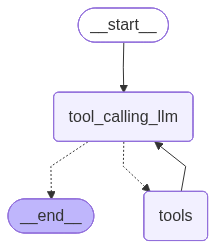

In [18]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_eee5ec06-30c2-4cc9-9aad-797071a0ed02)
 Call ID: fc_eee5ec06-30c2-4cc9-9aad-797071a0ed02
  Args:
    query: March 3 2025 AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "March 2025 round-up of interesting AI news and announcements - Artificial intelligence", "url": "https://nationalcentreforai.jiscinvolve.org/wp/2025/03/27/march-2025-round-up-of-interesting-ai-news-and-announcements/", "content": "We value your privacy\n\nWe use cookies to enhance your browsing experience, serve personalized ads or content, and analyze our traffic. By clicking \"Accept All\", you consent to our use of cookies.\n\nSkip to th

In [20]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning (ML)** is a subfield of artificial intelligence that focuses on building algorithms and statistical models that allow computers to perform specific tasks without being explicitly programmed for each task. In other words, instead of writing detailed rules for every possible situation, you give a machine a large amount of data and let it discover patterns, relationships, and rules on its own.

### Core Ideas

| Concept | What it means | Typical use |
|---------|---------------|-------------|
| **Data‑driven** | ML models learn from examples (training data). | Spam filtering, image recognition |
| **Pattern discovery** | Models identify regularities and structures in data. | Recommendation systems, anomaly detection |
| **Generalization** | After training, the model can make predictio

### Agent Memory
#### Aim
Lets introduce Agent With Memory

In [21]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================

5 + 8 = **13**


In [22]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

Sure! Could you let me know what number or expression you’d like me to divide by 5?


#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!



In [23]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")
llm_with_tools=llm.bind_tools(tools)

In [24]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")




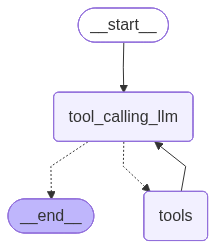

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [26]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_89f6665d-4ed4-4384-8772-7b7f424759d9)
 Call ID: fc_89f6665d-4ed4-4384-8772-7b7f424759d9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25


In [27]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_89f6665d-4ed4-4384-8772-7b7f424759d9)
 Call ID: fc_89f6665d-4ed4-4384-8772-7b7f424759d9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (fc_02c7c8ea-c5ae-4b74-86a1-c426cd81beec)
 Call ID: fc_02c7c8ea-c5ae-4b74-86a1-c426cd81beec
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

50


In [28]:
messages = [HumanMessage(content="then multiplty that number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_89f6665d-4ed4-4384-8772-7b7f424759d9)
 Call ID: fc_89f6665d-4ed4-4384-8772-7b7f424759d9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (fc_02c7c8ea-c5ae-4b74-86a1-c426cd81beec)
 Call ID: fc_02c7c8ea-c5ae-4b74-86a1-c426cd81beec
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

50
=

In [40]:
messages = [HumanMessage(content="then divide that number by 10")]
messages=graph_memory.invoke({"messages":messages},config)
for m in messages['messages']:
    m.pretty_print()
    # s

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_89f6665d-4ed4-4384-8772-7b7f424759d9)
 Call ID: fc_89f6665d-4ed4-4384-8772-7b7f424759d9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (fc_02c7c8ea-c5ae-4b74-86a1-c426cd81beec)
 Call ID: fc_02c7c8ea-c5ae-4b74-86a1-c426cd81beec
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

50
=